In [1]:
# Если честно все эти импорты смотрятся ужасно..
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import warnings
warnings.simplefilter('ignore')

%pylab inline
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 6,3

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Я взял базу данных с фильмами и убрал null
df = pd.read_csv('tmdb_5000_movies.csv')
df = df.dropna()

In [3]:
# Смотрим что есть в фильмах
df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


### 1. Количество фильмов, выпущенное каждой страной
Построим pie-chart в котором будет отображена доля каждой страны в производстве фильма.
Если в производстве одного фильма учавствовало несколько стран, то учитываем все.

Переменные:
1. Страна (строка)
2. Количество фильмов (целое)

In [4]:
import json
from collections import defaultdict


'''
Тут я делаю магию.. Если в кратце, то я получаю список стран, кладу из в country_list, потом делаю из него хеш,
в котором ключ - страна, значение - сколько фильмов было снято в этой стране. Ну а потом строю график по этому хешу
'''

def extract_country(prog_countries_json, countries):
    '''Функция которая парсит json, берет название стран, которые сделали фильм
    и записывает значение в countries (это список)'''
    country_items = json.loads(prog_countries_json)
    countries += [item['name'] for item in country_items]

country_list = []
df['production_countries'].apply(extract_country, countries=country_list)

country_dict = defaultdict(int)
for item in country_list:
    country_dict[item] += 1

data = go.Pie(labels=list(country_dict.keys()), values=list(country_dict.values()))
fig = go.Figure(data=[data], layout={'title': 'Films by country'})
iplot(fig)

### 2. Количество фильмов, выпущенных в каждом году

Для того чтобы узнать сколько было произведено фильмов по годам.

Переменные:
1. Количество фильмов (целое)
2. Год релиза (целое)

In [5]:
df['release_year'] = df.apply(lambda x: x['release_date'].split('-')[0], axis=1)
films_by_years = df.groupby('release_year').count().reset_index()

data = go.Bar(
    x=films_by_years.release_year,
    y=films_by_years.id,
    name='Films by years',
    orientation = 'v',
)
layout = go.Layout(title='Films by years', xaxis={'title': 'Years'}, yaxis={'title': 'Films count'})

fig = go.Figure(data=[data], layout=layout)
iplot(fig, show_link=False)

### 3. ТОП 15 лучих фильмов всех времен и народов (топ 15 фильмов по рейтингу)
Ну я думаю достаточно логичный график, нет смысла что-то подробно расписывать

In [6]:
df.sort_values(['vote_average'], ascending=False).head(15)[['title', 'vote_average']].set_index('title').style.bar()

,vote_average
title,
The Godfather,8.4
Whiplash,8.3
Schindler's List,8.3
Fight Club,8.3
Spirited Away,8.3
GoodFellas,8.2
The Dark Knight,8.2
The Green Mile,8.2
The Empire Strikes Back,8.2


### 4. Теперь будем смотреть корреляцию. А именно то, есть ли связь между уровнем оценок критиков с популярностью фильмов
Ну тут думаю все понятно какие оси и какая идея граффика.

P.S. Интересно насколько объективен параметр "популярность"

P.P.S. Ого, какие у нас выбросы есть..

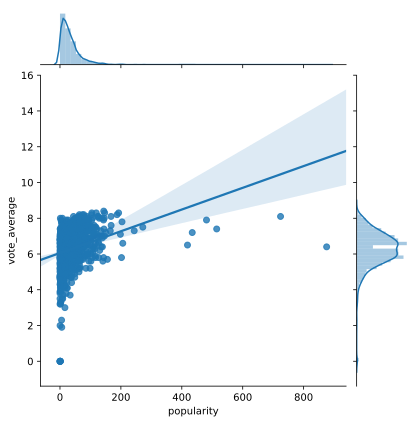

In [7]:
%config InlineBackend.figure_format = 'png'
sns.jointplot(x='popularity', y='vote_average', 
              data=df, kind='reg');
%config InlineBackend.figure_format = 'svg' 

### 5. Ну и напоследок сделаем красивый график свечек. Посмотрим распределение оценок криков по жанрам.

Единственный неприятный момент: в genres находится массив из жанров. Я возьму первый в списке жанр наивно полагая что он - основной.

In [8]:
import json

def extract_main_genre(genres_json):
    '''Достаем жанр фильма из json. Берем первое значение из списка.'''
    genres = json.loads(genres_json)
    if type(genres) is list and len(genres) > 0:
        return genres[0]['name']
    return None

df['genre_main'] = df['genres'].apply(extract_main_genre)

data = []
for genre in df.genre_main.unique():
    data.append(
        go.Box(y=df[df.genre_main==genre].vote_average, 
               name=genre)
    )
iplot(data, show_link = False)